# Binary encoding

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, DepthwiseConv2D
import tensorflow as tf

In [ ]:
# Opciones de decodificación para otros parámetros
layer_type_options = {
    0: 'Conv2D', 
    1: 'BatchNorm', 
    2: 'MaxPooling', 
    3: 'Dropout', 
    4: 'Dense', 
    5: 'Flatten',
    6: 'DepthwiseConv2D',  
    7: 'DontCare',  
    8: 'Repetition'
}
stride_options = {0: 1, 1: 2}
dropout_options = {0: 0.2, 1: 0.3, 2: 0.4, 3: 0.5}
activation_options = {0: 'relu', 1: 'leaky_relu', 2: 'sigmoid', 3: 'tanh'}

# Función para codificar los parámetros de la capa
def encode_layer_params(layer_type_idx, param1=0, param2=0, param3=0):
    """
    Codifica una capa en una lista en función del tipo de capa y sus parámetros.
    
    layer_type_idx : int : índice del tipo de capa según layer_type_options.
    param1         : int/float : filtros, neuronas, capas de repetición, etc.
    param2         : int : stride, número de repeticiones, etc.
    param3         : int : índice de activación o tasa de dropout.
    """
    return [layer_type_idx, param1, param2, param3]

# Función para decodificar los parámetros de la capa
def decode_layer_params(encoded_params):
    """
    Decodifica una capa desde su representación codificada en parámetros interpretables.
    
    encoded_params : list : [tipo de capa, param1, param2, param3].
    """
    layer_type_idx = encoded_params[0]
    layer_type = layer_type_options.get(layer_type_idx, 'DontCare')
    
    # Decodificar en función del tipo de capa
    if layer_type in ['Conv2D', 'DepthwiseConv2D']:
        filters = max(4, min(encoded_params[1], 32))  # Limitar filtros entre 4 y 32
        strides = stride_options.get(encoded_params[2], 1)
        activation = activation_options.get(encoded_params[3], 'relu')
        return {
            'type': layer_type,
            'filters': filters,
            'strides': strides,
            'activation': activation
        }
    elif layer_type == 'BatchNorm':
        return {'type': 'BatchNorm'}
    elif layer_type == 'MaxPooling':
        strides = stride_options.get(encoded_params[1], 1)
        return {'type': 'MaxPooling', 'strides': strides}
    elif layer_type == 'Dropout':
        rate = dropout_options.get(encoded_params[1], 0.2)
        return {'type': 'Dropout', 'rate': rate}
    elif layer_type == 'Dense':
        units = max(1, min(encoded_params[1], 512))  # Limitar unidades entre 1 y 512
        activation = activation_options.get(encoded_params[2], 'relu')
        return {'type': 'Dense', 'units': units, 'activation': activation}
    elif layer_type == 'Flatten':
        return {'type': 'Flatten'}
    elif layer_type == 'Repetition':
        return {
            'type': 'Repetition',
            'repetition_layers': int(encoded_params[1]),
            'repetition_count': int(encoded_params[2])
        }
    elif layer_type == 'DontCare':
        return {'type': "DontCare"}

    return None

# Ejemplos de codificación y decodificación
encoded_conv2d = encode_layer_params(0, 16, 0, 0)  # Conv2D con 16 filtros, stride 1 y activación ReLU
decoded_conv2d = decode_layer_params(encoded_conv2d)
print(f"\nCodificación real de Conv2D: {encoded_conv2d}")
print(f"Decodificación Conv2D: {decoded_conv2d}")

encoded_dropout = encode_layer_params(3, 1)  # Dropout con tasa de 0.3
decoded_dropout = decode_layer_params(encoded_dropout)
print(f"\nCodificación real de Dropout: {encoded_dropout}")
print(f"Decodificación Dropout: {decoded_dropout}")

encoded_dense = encode_layer_params(4, 128, 0)  # Dense con 128 neuronas y activación ReLU
decoded_dense = decode_layer_params(encoded_dense)
print(f"\nCodificación real de Dense: {encoded_dense}")
print(f"Decodificación Dense: {decoded_dense}")

encoded_repetition = encode_layer_params(8, 3, 5)  # Repetition para repetir las últimas 3 capas 5 veces
decoded_repetition = decode_layer_params(encoded_repetition)
print(f"\nCodificación real de Repetition: {encoded_repetition}")
print(f"Decodificación Repetition: {decoded_repetition}")


## Complete archs


In [3]:
# Clase para capas neutrales 'DontCare'
class DontCareLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DontCareLayer, self).__init__()

    def call(self, inputs):
        return inputs

In [4]:
def encode_model_architecture(model_dict, max_alleles=48):
    """
    Codifica la arquitectura del modelo en una lista de valores con un máximo de `max_alleles`.
    Cada capa se codifica en función de sus parámetros.
    """
    encoded_layers = []
    total_alleles = 0

    for layer in model_dict['layers']:
        if layer['type'] == 'Repetition':  # Codificar capa de repetición
            encoded_layer = encode_layer_params(
                layer_type_idx=8,  # índice para 'Repetition'
                param1=layer.get('repetition_layers', 0),
                param2=layer.get('repetition_count', 1)
            )
        else:
            layer_type_idx = next(
                key for key, value in layer_type_options.items() if value == layer['type']
            )
            
            # Codificar parámetros específicos de cada tipo de capa
            if layer['type'] in ['Conv2D', 'DepthwiseConv2D']:  
                # Limitar filtros dentro del rango [4, 32]
                param1 = max(4, min(layer.get('filters', 8), 32))  
                param2 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                param3 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, param3]

            elif layer['type'] == 'Dense':
                # Limitar neuronas dentro del rango [1, 512]
                param1 = max(1, min(layer.get('units', 1), 512))
                param2 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, 0]

            elif layer['type'] == 'MaxPooling':
                param1 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'Dropout':
                param1 = next((key for key, value in dropout_options.items() if value == layer.get('rate', 0.2)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'BatchNorm':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'Flatten':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'DontCare':
                encoded_layer = [layer_type_idx, 0, 0, 0]

        # Añadir la codificación de la capa a la lista de alelos
        encoded_layers.extend(encoded_layer)
        total_alleles += len(encoded_layer)

    # Rellenar con 'DontCare' si el total de alelos es menor que `max_alleles`
    while total_alleles < max_alleles:
        dont_care_encoding = encode_layer_params(7)  # índice de 'DontCare'
        encoded_layers.extend(dont_care_encoding)
        total_alleles += len(dont_care_encoding)

    # Recortar si excede `max_alleles`
    final_encoding = encoded_layers[:max_alleles]
    print(f"Final Encoded Model: {final_encoding}")
    
    return final_encoding


In [5]:
import random

def fixArch(encoded_model, verbose=False):
    """
    Corrige la arquitectura codificada del modelo, asegurando que:
    - Se evite la presencia de capas incompatibles después de una capa Flatten.
    - En caso de una capa de Repetition, se ajuste el alcance de repetición si no hay suficientes capas anteriores.

    Parameters:
        encoded_model (list): Lista codificada de la arquitectura del modelo.
        verbose (bool): Si es True, muestra las correcciones realizadas.

    Returns:
        list: Lista con la arquitectura corregida, truncada a un máximo de 48 alelos.
    """

    fixed_layers = []  # Lista que almacenará la arquitectura corregida
    input_is_flattened = False  # Indicador para saber si ya hay una capa Flatten en el modelo
    index = 0  # Índice para recorrer el modelo codificado

    # Procesar cada capa en el modelo sin forzar la primera capa a ser específica
    while index < len(encoded_model) and len(fixed_layers) < 48:
        layer_type = int(encoded_model[index])  # Obtener el tipo de capa actual

        # Procesar la capa de Repetition
        if layer_type == 8:
            repetition_layers = int(encoded_model[index + 1])  # Número de capas a repetir
            repetition_count = min(max(int(encoded_model[index + 2]), 0), 32)  # Cantidad de repeticiones

            # Verificar si hay suficientes capas para la repetición solicitada
            actual_layers_to_repeat = min(repetition_layers, len(fixed_layers) // 4)

            if actual_layers_to_repeat != repetition_layers:
                if verbose:
                    print(f"Ajustando alcance de repetición de {repetition_layers} a {actual_layers_to_repeat} debido a falta de capas.")
                repetition_layers = actual_layers_to_repeat

            # Añadir la capa de repetición sin modificar su estructura
            fixed_layers.extend([layer_type, repetition_layers, repetition_count, 0])
            index += 4
            continue

        # Procesar cada tipo de capa normal con sus restricciones
        if layer_type == 0:  # Conv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 6:  # DepthwiseConv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 2:  # MaxPooling
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                stride_idx = min(max(int(encoded_model[index + 1]), 0), 1)
                fixed_layers.extend([layer_type, stride_idx, 0, 0])

        elif layer_type == 3:  # Dropout
            rate_idx = min(max(int(encoded_model[index + 1]), 0), 3)
            fixed_layers.extend([layer_type, rate_idx, 0, 0])

        elif layer_type == 4:  # Dense
            # Limitar el número de neuronas entre 1 y 512
            neurons = min(max(int(encoded_model[index + 1]), 1), 512)
            activation_idx = min(max(int(encoded_model[index + 2]), 0), 3)
            fixed_layers.extend([layer_type, neurons, activation_idx, 0])

        elif layer_type == 1:  # BatchNorm
            fixed_layers.extend([layer_type, 0, 0, 0])

        elif layer_type == 5:  # Flatten
            if len(fixed_layers) < 16:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            elif input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                fixed_layers.extend([layer_type, 0, 0, 0])
                input_is_flattened = True  # Marcar que ya hay un Flatten

        elif layer_type == 7:  # DontCare
            fixed_layers.extend([layer_type, 0, 0, 0])

        else: # DontCare
          fixed_layers.extend([7, 0, 0, 0])

        index += 4  # Avanzar al siguiente grupo de parámetros

    return fixed_layers[:48]  # Limitar a 48 alelos


In [ ]:
# Ejecutar ejemplos de prueba para la función fixArch con arquitecturas de 12 capas (48 valores en total)

# Ejemplo 1: Arquitectura sin Flatten antes de Dense y con capas adicionales
encoded_model_1 = [
    0, 3, 0, 0,    # Conv2D, 32 filtros, stride 1, activación relu
    2, 1, 0, 0,    # MaxPooling, stride 2
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu (sin Flatten antes)
    7, 0, 0, 0,    # DontCare
    1, 0, 0, 0,    # BatchNorm
    3, 2, 0, 0,    # Dropout, tasa 0.4
    0, 1, 1, 0,    # Conv2D, 16 filtros, stride 2, activación relu
    6, 1, 1, 0,    # DepthwiseConv2D, 16 filtros, stride 2, activación relu
    5, 0, 0, 0,    # Flatten
    4, 3, 2, 0,    # Dense, 256 neuronas, activación sigmoid
    4, 1, 3, 0,    # Dense, 32 neuronas, activación tanh
    4, 1, 2, 0     # Dense, 32 neuronas, activación sigmoid
]

# Ejemplo 2: Arquitectura con Flatten al inicio (inválido) y sin Dense al final
encoded_model_2 = [
    5, 0, 0, 0,    # Flatten (inválido al inicio)
    0, 2, 1, 1,    # Conv2D, 30 filtros, stride 2, activación leaky_relu
    2, 1, 0, 0,    # MaxPooling, stride 2
    3, 1, 0, 0,    # Dropout, tasa 0.3
    1, 0, 0, 0,    # BatchNorm
    0, 1, 0, 0,    # Conv2D, 16 filtros, stride 1, activación relu
    6, 2, 1, 0,    # DepthwiseConv2D, 30 filtros, stride 2, activación relu
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu
    3, 0, 0, 0,    # Dropout, tasa 0.2
    1, 0, 0, 0,    # BatchNorm
    4, 3, 3, 0,    # Dense, 256 neuronas, activación tanh
    7, 0, 0, 0     # DontCare
]

# Ejemplo 3: Arquitectura con Repetition y sin Dense al final
encoded_model_3 = [
    0, 1, 0, 0,    # Conv2D, 16 filtros, stride 1, activación relu
    8, 2, 2, 0,    # Repetition, repite las últimas 2 capas 2 veces
    5, 0, 0, 0,    # Flatten
    2, 1, 0, 0,    # MaxPooling, stride 2
    3, 1, 0, 0,    # Dropout, tasa 0.3
    6, 2, 1, 0,    # DepthwiseConv2D, 30 filtros, stride 2, activación relu
    0, 3, 0, 1,    # Conv2D, 32 filtros, stride 1, activación leaky_relu
    1, 0, 0, 0,    # BatchNorm
    5, 0, 0, 0,    # Flatten
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu
    7, 0, 0, 0,    # DontCare
    3, 2, 0, 0     # Dropout, tasa 0.4
]

# Ejemplo 4: Arquitectura con parámetros fuera de límite
encoded_model_4 = [
    0, 4, 2, 1,    # Conv2D, 64 filtros (fuera de límite), stride 2, activación leaky_relu
    3, 5, 0, 0,    # Dropout, tasa 0.6 (fuera de límite)
    4, 5, 3, 0,    # Dense, 512 neuronas (fuera de límite), activación sigmoid
    6, 4, 2, 0,    # DepthwiseConv2D, 64 filtros (fuera de límite), stride 2, activación relu
    1, 0, 0, 0,    # BatchNorm
    3, 3, 0, 0,    # Dropout, tasa 0.5
    5, 0, 0, 0,    # Flatten
    2, 1, 0, 0,    # MaxPooling, stride 2
    0, 1, 0, 0,    # Conv2D, 16 filtros, stride 1, activación relu
    4, 3, 1, 0,    # Dense, 256 neuronas, activación leaky_relu
    7, 0, 0, 0,    # DontCare
    4, 1, 2, 0     # Dense, 32 neuronas, activación sigmoid
]
# Ejemplo 5: Arquitectura con capa de Repetition que repite las últimas capas
encoded_model_5 = [
    0, 2, 1, 0,    # Conv2D, 30 filtros, stride 2, activación relu
    8, 2, 3, 0,    # Repetition, repite las últimas 2 capas 3 veces
    5, 0, 0, 0,    # Flatten
    2, 1, 0, 0,    # MaxPooling, stride 2
    3, 1, 0, 0,    # Dropout, tasa 0.3
    6, 2, 1, 0,    # DepthwiseConv2D, 30 filtros, stride 2, activación relu
    0, 3, 0, 1,    # Conv2D, 32 filtros, stride 1, activación leaky_relu
    1, 0, 0, 0,    # BatchNorm
    5, 0, 0, 0,    # Flatten
    4, 2, 1, 0,    # Dense, 128 neuronas, activación leaky_relu
    7, 0, 0, 0,    # DontCare
    3, 2, 0, 0     # Dropout, tasa 0.4
]

# Lista de modelos para probar
model_examples = [encoded_model_1, encoded_model_2, encoded_model_3, encoded_model_4, encoded_model_5]

# Ejecución de pruebas
for i, model in enumerate(model_examples, 1):
    print(f"\n--- Ejemplo {i} ---")
    fixed_model = fixArch(model, verbose=True)
    print(f"Modelo Original: {len(model)} alelos\n{model}") 
    print(f"Modelo Corregido: {len(fixed_model)} alelos\n{fixed_model}")


In [7]:
def decode_model_architecture(encoded_model):
    """
    Decodifica la arquitectura del modelo a partir de la lista codificada de valores (índices),
    aplicando las reglas de repetición y asegurando la inclusión de una capa convolucional inicial.
    """
    model_dict = {'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}]}  # Inserta Conv2D inicial
    index = 0

    while index < len(encoded_model):
        layer_type = int(encoded_model[index])
        param1 = encoded_model[index + 1]
        param2 = encoded_model[index + 2]
        param3 = encoded_model[index + 3]

        if layer_type == 8:  # Capa de Repetition
            repetition_layers = int(param1)
            repetition_count = int(param2)
            # Selecciona solo el grupo válido de capas para la repetición
            layers_to_repeat = select_group_for_repetition(model_dict['layers'], repetition_layers)
            
            if len(layers_to_repeat) > 0:
                for _ in range(repetition_count):
                    model_dict['layers'].extend(layers_to_repeat)

        else:
            decoded_layer = {}

            if layer_type == 0:  # Conv2D
                decoded_layer = {
                    'type': 'Conv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 6:  # DepthwiseConv2D
                decoded_layer = {
                    'type': 'DepthwiseConv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 2:  # MaxPooling
                decoded_layer = {
                    'type': 'MaxPooling',
                    'strides': stride_options.get(param1, 1)
                }
            elif layer_type == 3:  # Dropout
                decoded_layer = {
                    'type': 'Dropout',
                    'rate': dropout_options.get(param1, 0.2)
                }
            elif layer_type == 4:  # Dense
                decoded_layer = {
                    'type': 'Dense',
                    'units': max(1, min(param1, 512)),  # Limita `units` entre 1 y 512
                    'activation': activation_options.get(param2, 'relu')
                }
            elif layer_type == 1:  # BatchNorm
                decoded_layer = {'type': 'BatchNorm'}
            elif layer_type == 5:  # Flatten
                decoded_layer = {'type': 'Flatten'}
            elif layer_type == 7:  # DontCare
                decoded_layer = {'type': 'DontCare'}

            model_dict['layers'].append(decoded_layer)

        index += 4

    # Asegura que haya una capa Flatten antes de la capa Dense final, si no ya existe una Flatten
    if model_dict['layers'][-1]['type'] != 'Flatten':
        model_dict['layers'].append({'type': 'Flatten'})
        
    # Añade la capa Dense final obligatoria
    model_dict['layers'].append({'type': 'Dense', 'units': 1, 'activation': 'sigmoid'})

    return model_dict

def select_group_for_repetition(layers, repetition_layers):
    """
    Selecciona el primer grupo válido para repetición en función de las reglas de compatibilidad.

    Parameters:
        layers (list): Lista de capas ya procesadas, donde cada capa es un diccionario.
        repetition_layers (int): Número de capas hacia atrás para considerar en la repetición.

    Returns:
        list: Lista de capas compatibles para repetición.
    """
    valid_layers = []
    group_type = None

    # Retrocede desde el final de `layers` para encontrar el grupo válido
    for layer in reversed(layers[-repetition_layers:]):
        if group_type is None:
            # Determina el tipo de grupo
            if layer['type'] in ['Flatten', 'Dense']:
                group_type = 'dense'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling']:
                group_type = 'convolutional'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['BatchNorm', 'DontCare']:  # BatchNorm y DontCare son compatibles con ambos grupos
                valid_layers.insert(0, layer)
        else:
            # Agrega solo capas compatibles con el grupo seleccionado
            if group_type == 'dense' and layer['type'] in ['Flatten', 'Dense', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)
            elif group_type == 'convolutional' and layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)

    return valid_layers


In [8]:
# # Reparar cada ejemplo con fixArch y luego decodificar con decode_model_architecture
# repaired_and_decoded_models = []

# for i, encoded_model in enumerate([encoded_model_1, encoded_model_2, encoded_model_3, encoded_model_4, encoded_model_5], 1):
#     # Reparar el modelo
#     repaired_model = fixArch(encoded_model, verbose=True)
#     # Decodificar el modelo reparado
#     decoded_model = decode_model_architecture(repaired_model)
#     # Guardar el modelo decodificado
#     repaired_and_decoded_models.append(decoded_model)
#     print(f"\n--- Modelo {i} Decodificado ---")
#     print(decoded_model)

# # Opcional: Mostrar todos los modelos decodificados juntos
# print("\n--- Todos los Modelos Decodificados ---")
# for i, model in enumerate(repaired_and_decoded_models, 1):
#     print(f"Modelo {i} Decodificado:", model)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, DepthwiseConv2D



def build_tf_model_from_dict(model_dict, input_shape=(28, 28, 3)):
    """
    Construye un modelo de TensorFlow a partir de un diccionario JSON expandido.
    """
    print("\nConstruyendo el modelo en TensorFlow desde el JSON expandido...")
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for layer in model_dict['layers']:
        if layer['type'] == 'Conv2D':
            model.add(Conv2D(filters=layer['filters'], kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))
        
        elif layer['type'] == 'DepthwiseConv2D':
            model.add(DepthwiseConv2D(kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))
        
        elif layer['type'] == 'BatchNorm':
            model.add(BatchNormalization())
        
        elif layer['type'] == 'MaxPooling':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=int(layer['strides']), padding='same'))
        
        elif layer['type'] == 'Flatten':
            model.add(Flatten())
        
        elif layer['type'] == 'Dense':
            model.add(Dense(units=int(layer['units']), activation=layer['activation']))
        
        elif layer['type'] == 'Dropout':
            model.add(Dropout(rate=layer['rate']))
        
        elif layer['type'] == 'DontCare':
            model.add(DontCareLayer())
    
    return model


In [10]:
# Ejemplo 1: build_CNN_LF_model
model_CNN_LF = {
    "layers": [
        {"type": "Conv2D", "filters": 30, "strides": 1, "activation": "relu"},
        {"type": "Dropout", "rate": 0.2},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Conv2D", "filters": 16, "strides": 1, "activation": "relu"},  # Revisar 'filters'
        {"type": "Dropout", "rate": 0.2},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Flatten"},
        {"type": "Dense", "units": 256, "activation": "relu"},
        {"type": "Dropout", "rate": 0.3},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 2: build_reduced_model
model_reduced = {
    "layers": [
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 16, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 8, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Flatten"},
        {"type": "Dense", "units": 32, "activation": "leaky_relu"},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 3: build_Spectro_CNN_model
model_spectro_CNN = {
    "layers": [
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "MaxPooling", "strides": 2}, 
         
         
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
         {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
         {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        
    {"type":"Flatten"},
    {"type":"Dense","units":256,"activation":"relu"},   
    {"type":"Dropout","rate":0.5},
                
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo corregido: build_Spectro_CNN_model con capas de repetición
model_spectro_CNN_with_repetition = {
    "layers": [
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "leaky_relu"},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2}, 
        # Aquí indicamos que las siguientes 10 capas (5 Conv2D + 5 BatchNorm) se repiten 10 veces
        {"type": "Repetition", "repetition_layers": 3, "repetition_count": 31},
        {"type": "Flatten"},
        {"type": "Dense", "units": 256, "activation": "relu"},
        {"type": "Dropout", "rate": 0.5},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}
    ]
}


# Ejemplo 4: Simple Conv2D model
model_simple_conv = {
    "layers": [
        {"type": "Conv2D", "filters": 16, "strides": 1, "activation": "relu"},
        {"type": "Flatten"},
        {"type": "Dense", "units": 128, "activation": "relu"},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 5: Simple Dense model
model_dense_only = {
    "layers": [
        {"type": "Flatten"},
        {"type": "Dense", "units": 256, "activation": "relu"},
        {"type": "Dense", "units": 128, "activation": "relu"},
        {"type": "Dense", "units": 256, "activation": "sigmoid"}
    ]
}

# Ejemplo 6: Small CNN model with Dropout
model_small_CNN = {
    "layers": [
        {"type": "Conv2D", "filters": 8, "strides": 1, "activation": "relu"},
        {"type": "Dropout", "rate": 0.2},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Flatten"},
        {"type": "Dense", "units": 32, "activation": "relu"},
        {"type": "Dense", "units": 1, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 7: Deep CNN model
model_deep_CNN = {
    "layers": [
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "relu"},
        {"type": "Conv2D", "filters": 32, "strides": 1, "activation": "relu"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Flatten"},
        {"type": "Dense", "units": 32, "activation": "relu"},
        {"type": "Dense", "units": 10, "activation": "sigmoid"}  # Revisar 'units'
    ]
}

# Ejemplo 8: Basic Dense with Dropout
model_dense_dropout = {
    "layers": [
        {"type": "Flatten"},
        {"type": "Dense", "units": 128, "activation": "relu"},
        {"type": "Dropout", "rate": 0.5},
        {"type": "Dense", "units": 32, "activation": "tanh"}
    ]
}

model_with_depthwise = {
    "layers": [
        {"type": "DepthwiseConv2D", "filters": 16, "strides": 1, "activation": "relu"},
        {"type": "BatchNorm"},
        {"type": "MaxPooling", "strides": 2},
        {"type": "Dense", "units": 128, "activation": "sigmoid"},
        {"type": "Dense", "units": 1, "activation": "tanh"}
    ]
}



In [11]:
def process_model_pipeline(model_dict, input_shape=(28, 28, 3), verbose=False):
    """
    Procesa el pipeline de creación del modelo desde el JSON inicial hasta el modelo de TensorFlow.
    
    Parameters:
        model_dict (dict): Modelo en formato JSON.
        input_shape (tuple): Forma de entrada para el modelo.
        verbose (bool): Si es True, muestra los detalles de cada etapa del proceso.
        
    Returns:
        tf.keras.Model: El modelo de TensorFlow construido a partir del JSON procesado.
    """
    # Codificar el modelo
    encoded_model = encode_model_architecture(model_dict, max_alleles=48)
    if verbose:
        print(f"\nModelo codificado: {encoded_model}")

    # Reparar el modelo codificado
    fixed_model = fixArch(encoded_model, verbose=verbose)
    if verbose:
        print(f"\nModelo codificado y reparado: {fixed_model}")

    # Decodificar el modelo reparado
    decoded_model = decode_model_architecture(fixed_model)
    if verbose:
        print(f"\nModelo decodificado:\n{decoded_model}")

    # Construir el modelo de TensorFlow
    tf_model = build_tf_model_from_dict(decoded_model, input_shape=input_shape)
    if verbose:
        print("\nModelo de TensorFlow construido.")
        tf_model.summary()
    
    return tf_model


# Ejemplo de uso con un modelo y verbose activado



In [ ]:

# Verificación de los modelos
print("Verifications:")

print("\nModel 1: CNN_LF")
tf_model_example = process_model_pipeline(model_CNN_LF, verbose=True)  # Ejemplo 1

print("\nModel 2: Reduced")
tf_model_example = process_model_pipeline(model_reduced, verbose=True)  # Ejemplo 2

print("\nModel 3: Spectro CNN")
tf_model_example = process_model_pipeline(model_spectro_CNN, verbose=True)  # Ejemplo 3

print("\nModel 3.5 Spectro CNN with repetition")
tf_model_example = process_model_pipeline(model_spectro_CNN_with_repetition, verbose=True)  # Ejemplo 3

print("\nModel 4: Simple Conv2D")
tf_model_example = process_model_pipeline(model_simple_conv, verbose=True)  # Ejemplo 4

print("\nModel 5: Dense Only")
tf_model_example = process_model_pipeline(model_dense_only, verbose=True)  # Ejemplo 5

print("\nModel 6: Small CNN")
tf_model_example = process_model_pipeline(model_small_CNN, verbose=True)  # Ejemplo 6

print("\nModel 7: Deep CNN")
tf_model_example = process_model_pipeline(model_deep_CNN, verbose=True)  # Ejemplo 7

print("\nModel 8: Dense with Dropout")
tf_model_example = process_model_pipeline(model_dense_dropout, verbose=True)  # Ejemplo 8

print("\nModel with DepthwiseConv2D")
tf_model_example = process_model_pipeline(model_with_depthwise)



# Testing random generated architectures


In [13]:
import csv
import numpy as np
from pyDOE2 import lhs

# Función para generar un hipercubo latino con rangos normalizados [0, 1]
def generate_latin_hypercube_samples(num_samples, dimensions):
    return lhs(dimensions, samples=num_samples)

# Validar si los parámetros generados están dentro del rango esperado
def validate_latin_hypercube(num_models=100):
    dimensions = 12 * 3  # 12 capas, 3 parámetros por capa
    latin_samples = generate_latin_hypercube_samples(num_models, dimensions)
    
    # Validar cada muestra generada
    for sample_idx, sample in enumerate(latin_samples):
        reshaped_sample = sample.reshape(12, 3)  # Cada modelo tiene 12 capas
        
        for layer_idx, layer_params in enumerate(reshaped_sample):
            # Validar parámetros individuales
            type_idx = int(layer_params[0] * 9)  # 9 tipos de capas
            param1 = layer_params[1]
            param2 = layer_params[2]

            # Verificar tipo de capa
            if type_idx not in range(9):
                print(f"ERROR en Modelo {sample_idx + 1}, Capa {layer_idx + 1}: Tipo inválido {type_idx}")
                return False

            # Verificar rangos específicos según el tipo de capa
            layer_mapping = ['Conv2D', 'DepthwiseConv2D', 'BatchNorm', 'MaxPooling', 
                             'Dropout', 'Dense', 'Flatten', 'DontCare', 'Repetition']
            layer_type = layer_mapping[type_idx]

            if layer_type in ['Conv2D', 'DepthwiseConv2D']:
                filters = int(param1 * (32 - 4) + 4)  # Filtros entre [4, 32]
                if not (4 <= filters <= 32):
                    print(f"ERROR en Modelo {sample_idx + 1}, Capa {layer_idx + 1}: Filtros fuera de rango {filters}")
                    return False

            elif layer_type == 'Dropout':
                rate = param1 * (0.5 - 0.2) + 0.2  # Tasa de dropout entre [0.2, 0.5]
                if not (0.2 <= rate <= 0.5):
                    print(f"ERROR en Modelo {sample_idx + 1}, Capa {layer_idx + 1}: Dropout fuera de rango {rate}")
                    return False

            elif layer_type == 'Dense':
                units = int(param1 * (512 - 1) + 1)  # Unidades entre [1, 512]
                if not (1 <= units <= 512):
                    print(f"ERROR en Modelo {sample_idx + 1}, Capa {layer_idx + 1}: Unidades fuera de rango {units}")
                    return False

    print("Validación completada: Todas las muestras están dentro de los rangos esperados.")
    return True

# Guardar el encoding generado en un archivo CSV
def save_encoded_models_to_csv(num_models, filename, max_alleles=48):
    # Generar muestras de hipercubo latino
    latin_samples = generate_latin_hypercube_samples(num_models, 12 * 3)  # 12 capas, 3 parámetros por capa

    # Crear el archivo CSV
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Escribir encabezados
        writer.writerow(["Model", "Encoded Chromosome"])

        for model_idx in range(num_models):
            # Cada modelo tiene 12 capas
            model_samples = latin_samples[model_idx].reshape(12, 3)

            # Mapear cada muestra a un modelo (JSON)
            model_dict = {
                "layers": [
                    map_to_architecture_params(sample) for sample in model_samples
                ]
            }

            # Realizar el encoding del modelo
            encoded_chromosome = encode_model_architecture(model_dict, max_alleles=max_alleles)

            # Guardar en el archivo CSV
            writer.writerow([model_idx + 1, encoded_chromosome])

    print(f"Cromosomas codificados guardados en {filename}")
    

# Mapear valores normalizados a arquitecturas
def map_to_architecture_params(latin_hypercube_sample):
    layer_type = int(latin_hypercube_sample[0] * 9)  # 9 tipos de capas
    layer_mapping = ['Conv2D', 'DepthwiseConv2D', 'BatchNorm', 'MaxPooling', 
                     'Dropout', 'Dense', 'Flatten', 'DontCare', 'Repetition']

    layer_type_name = layer_mapping[layer_type]

    if layer_type_name == 'Conv2D':
        return {
            "type": "Conv2D",
            "filters": int(latin_hypercube_sample[1] * (16 - 4) + 4),  # [4, 16]
            "strides": 1 if latin_hypercube_sample[2] < 0.5 else 2,
            "activation": "relu"
        }
    elif layer_type_name == 'DepthwiseConv2D':
        return {
            "type": "DepthwiseConv2D",
            "filters": int(latin_hypercube_sample[1] * (16 - 4) + 4),
            "strides": 1 if latin_hypercube_sample[2] < 0.5 else 2,
            "activation": "relu"
        }
    elif layer_type_name == 'BatchNorm':
        return {"type": "BatchNorm"}
    elif layer_type_name == 'MaxPooling':
        return {"type": "MaxPooling", "strides": 1 if latin_hypercube_sample[1] < 0.5 else 2}
    elif layer_type_name == 'Dropout':
        return {"type": "Dropout", "rate": latin_hypercube_sample[1] * (0.5 - 0.2) + 0.2}
    elif layer_type_name == 'Dense':
        return {
            "type": "Dense",
            "units": int(latin_hypercube_sample[1] * (128 - 1) + 1),
            "activation": "relu"
        }
    elif layer_type_name == 'Flatten':
        return {"type": "Flatten"}
    elif layer_type_name == 'DontCare':
        return {"type": "DontCare"}
    elif layer_type_name == 'Repetition':
        return {
            "type": "Repetition",
            "repetition_layers": int(latin_hypercube_sample[1] * 3 + 1),
            "repetition_count": int(latin_hypercube_sample[2] * 2 + 1)
        }
    return {}

# Ejecutar validación
# if validate_latin_hypercube(num_models=100):
#     # Guardar los cromosomas codificados en un archivo CSV si la validación pasa
#     save_encoded_models_to_csv(num_models=1000, filename="EncodedChromosomes.csv")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Función para cargar el CSV y extraer las muestras normalizadas
def load_and_plot_samples(filename):
    # Cargar el archivo CSV
    data = pd.read_csv(filename)

    # Asegurarse de que las muestras están en una columna separada correctamente
    # Convertir la columna "Encoded Chromosome" de string a listas
    data['Encoded Chromosome'] = data['Encoded Chromosome'].apply(
        lambda x: [int(i) for i in x.strip("[]").split(",")]
    )

    # Para este ejemplo, asumiremos que los parámetros 1 y 2 corresponden a las dimensiones de interés
    # Extraer dimensiones de interés de los cromosomas codificados
    dimension_1 = [chromosome[0] for chromosome in data['Encoded Chromosome']]  # Tipo de la primera capa
    dimension_2 = [chromosome[1] for chromosome in data['Encoded Chromosome']]  # Número de filtros/unidades

    # Normalizar dimensiones para que caigan en [0, 1]
    dimension_1 = np.array(dimension_1) / max(dimension_1)
    dimension_2 = np.array(dimension_2) / max(dimension_2)

    # Crear un histograma bidimensional (mapa de calor)
    heatmap, xedges, yedges = np.histogram2d(dimension_1, dimension_2, bins=20, range=[[0, 1], [0, 1]])

    # Configurar la figura
    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Dibujar el mapa de calor
    cbar = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(cbar, label="Densidad de muestras")
    ax.set_title("Mapa de calor del espacio de búsqueda")
    ax.set_xlabel("Tipo de capa normalizado (Dimensión 1)")
    ax.set_ylabel("Número de filtros/unidades normalizado (Dimensión 2)")

    # Mostrar la figura
    plt.show()

# Llamar a la función con el archivo generado
load_and_plot_samples("EncodedChromosomes.csv")


# Entrenando el modelo surogado


In [ ]:
import os
import copy
import json
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import torchaudio
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Resizing, Conv2D, Dropout, BatchNormalization, MaxPooling2D, MaxPool2D, Flatten, Dense, Input, LeakyReLU
from tqdm import tqdm
import tensorflow_addons as tfa

# Configuración de parámetros
class Config:
    def __init__(self, architecture='random', epochs=50, sample_rate=None, time=5, n_splits=5, window_size=5, checkpoint_file="training_checkpoint.json"):
        self.architecture = architecture
        self.epochs = epochs
        self.sample_rate = sample_rate
        self.time = time
        self.n_splits = n_splits
        self.window_size = window_size
        self.checkpoint_file = checkpoint_file

# Crear o cargar checkpoint
def load_checkpoint(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            checkpoint = json.load(f)
            print(f"Checkpoint cargado: {checkpoint}")
            return checkpoint
    return {"last_completed": -1}

def save_checkpoint(file_path, architecture_index):
    checkpoint = {"last_completed": architecture_index}
    with open(file_path, 'w') as f:
        json.dump(checkpoint, f)
    print(f"Checkpoint guardado: {checkpoint}")

# Cargar datos de audio
def load_audio_data(directory, window_size, sample_rate):
    audio_dict = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".wav"):
            waveform, sr = torchaudio.load(os.path.join(directory, file_name))
            if sample_rate is None:
                sample_rate = sr
            num_windows = int(waveform.shape[1] / (window_size * sample_rate))
            for i in range(num_windows):
                start = i * window_size * sample_rate
                end = (i + 1) * window_size * sample_rate
                audio_dict[f"{file_name}_{i}"] = waveform[:, start:end].numpy()
    return audio_dict, sample_rate

# Preprocesar datos de audio
def preprocess_audio(audio_dict, sample_rate):
    audio_dict = copy.deepcopy(audio_dict)
    n_mels = 128
    n_fft = int(sample_rate * 0.029)
    hop_length = int(sample_rate * 0.010)
    win_length = int(sample_rate * 0.025)

    for filename, waveform in tqdm(audio_dict.items(), desc='MELSPECTROGRAM'):
        waveform = torch.from_numpy(waveform)
        spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length)(waveform)
        spec = torchaudio.transforms.AmplitudeToDB()(spec)
        spec = spec.numpy()
        spec = (spec - spec.min()) / (spec.max() - spec.min())
        audio_dict[filename] = spec
    return audio_dict

# Padding de los espectrogramas
def pad_and_crop_spectrograms(spectrograms, target_shape=(128, 128)):
    padded_spectrograms = []
    for spec in spectrograms:
        if spec.shape[0] > target_shape[0]:
            spec = spec[:target_shape[0], :]
        if spec.shape[1] > target_shape[1]:
            spec = spec[:, :target_shape[1]]
        
        pad_width = [(0, max(0, target_shape[0] - spec.shape[0])), 
                     (0, max(0, target_shape[1] - spec.shape[1]))]
        
        padded_spec = np.pad(spec, pad_width, mode='constant')
        padded_spectrograms.append(padded_spec)
    return np.array(padded_spectrograms)

# Split de audio en train y test
def train_test_split_audio(audio_dict):
    df = pd.read_csv('Dataset.csv', usecols=['Participant_ID', 'PHQ-9 Score'], dtype={1: str})
    df['labels'] = np.zeros([len(df),], dtype=int)
    df.loc[df['PHQ-9 Score'] < 10, 'labels'] = 0
    df.loc[df['PHQ-9 Score'] >= 10, 'labels'] = 1

    labels = df.set_index('Participant_ID').to_dict()['labels']

    X, Y = [], []
    for filename, data in tqdm(audio_dict.items(), 'LABEL'):
        ID = filename[:3]
        if ID in labels:
            dep = 0 if labels[ID] == 0 else 1
            [X.append(x) for x in data]
            [Y.append(dep) for x in data]

    X = pad_and_crop_spectrograms(X)
    Y = np.array(Y)

    X = X[..., np.newaxis]
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y

# Guardar resultados en CSV (append)
def append_results_to_csv(file_path, model_results):
    columns = ["Encoded Architecture", "Loss", "Accuracy", "Precision", "Recall", "F1", "Specificity"]

    # Convertir arquitectura a cadena para guardar
    model_results = [str(model_results[0])] + model_results[1:]

    # Verificar si el archivo ya existe
    if not os.path.exists(file_path):
        # Crear archivo con encabezados si no existe
        with open(file_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(columns)

    # Escribir resultados en el archivo
    with open(file_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(model_results)
    print(f"Resultados guardados en: {file_path}")

# Función de especificidad
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Entrenar y evaluar modelo
def train_and_evaluate_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config):
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy", 'Precision', 'Recall'])
    model.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), verbose=0)
    results = model.evaluate(X_test, Y_test, verbose=0)

    # Obtener predicciones para métricas adicionales
    Y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = results[1]
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    specificity = specificity_score(Y_test, Y_pred)

    return [results[0], accuracy, precision, recall, f1, specificity]

# Evaluar y almacenar resultados
def evaluate_and_store_model(architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, stratified_kfold, target_shape, results_file):
    repaired_architecture = fixArch(architecture)
    decoded_model_dict = decode_model_architecture(repaired_architecture)
    model_results = [repaired_architecture]

    if use_kfold:
        fold_results = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train_val, Y_train_val)):
            print(f"Entrenando fold {fold + 1}/{config.n_splits}...")
            X_train, X_val = X_train_val[train_index], X_train_val[val_index]
            Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]
            tf_model = build_tf_model_from_dict(decoded_model_dict, input_shape=(target_shape[0], target_shape[1], 1))
            fold_results.append(train_and_evaluate_model(tf_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config))
            print(f"Fold {fold + 1} completado.")

        avg_results = np.mean(fold_results, axis=0)
        model_results.extend(avg_results)

    else:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=42)
        tf_model = build_tf_model_from_dict(decoded_model_dict, input_shape=(target_shape[0], target_shape[1], 1))
        single_run_results = train_and_evaluate_model(tf_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, config)
        model_results.extend(single_run_results)
        print("Modelo evaluado sin K-Fold Cross Validation.")

    # Guardar métricas de la arquitectura actual en el archivo CSV
    append_results_to_csv(results_file, model_results)

# Cargar arquitecturas desde un archivo CSV
def load_architectures_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    architectures = df['Encoded Chromosome'].apply(lambda x: [int(i) for i in x.strip("[]").split(",")])
    return architectures.tolist()

# Entrenar los modelos cargados
def train_loaded_models(csv_path, directory='./SM-27', target_shape=(128, 128, 1), use_kfold=True, epochs=50, n_splits=5, checkpoint_file="training_checkpoint.json", results_file="./model_results_loaded_architectures.csv"):
    config = Config(epochs=epochs, n_splits=n_splits, checkpoint_file=checkpoint_file)
    
    # Cargar checkpoint
    checkpoint = load_checkpoint(config.checkpoint_file)

    # Cargar y preprocesar datos de audio
    print("Cargando y preprocesando datos de audio...")
    audio_dict, sample_rate = load_audio_data(directory, config.window_size, config.sample_rate)
    audio_dict = preprocess_audio(audio_dict, sample_rate)
    X, Y = train_test_split_audio(audio_dict)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    if use_kfold:
        stratified_kfold = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=42)

    # Cargar arquitecturas desde el archivo CSV
    architectures = load_architectures_from_csv(csv_path)

    # Entrenar y evaluar las arquitecturas desde el último punto
    for i, architecture in enumerate(architectures):
        if i <= checkpoint["last_completed"]:
            continue  # Saltar arquitecturas ya completadas

        print(f"\nEvaluando arquitectura {i + 1}/{len(architectures)}...")
        evaluate_and_store_model(architecture, X_train_val, X_test, Y_train_val, Y_test, config, use_kfold, stratified_kfold, target_shape, results_file)

        # Guardar checkpoint
        save_checkpoint(config.checkpoint_file, i)

# Ejecutar
train_loaded_models(csv_path="EncodedChromosomes.csv", target_shape=(128, 128, 1), use_kfold=True, epochs=18, n_splits=5, results_file="./model_results_loaded_architectures.csv")


## Revisando distribucion del dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset desde el archivo CSV
file_path = './model_results_loaded_architectures.csv'
df = pd.read_csv(file_path)

# Especificar las métricas a graficar
metrics = ["Loss", "Accuracy", "Precision", "Recall", "F1", "Specificity"]

# Crear un único plot con subplots para cada métrica
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].hist(df[metric], bins=10, alpha=0.7, color="blue", edgecolor="black")
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


## Creación del modelo

## XGBoostB

In [24]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import joblib
import pandas as pd

# Cargar los datos
data = pd.read_csv('./model_results_loaded_architectures.csv')

# Convertir la columna 'Encoded Architecture' de strings a listas de enteros
data['Encoded Architecture'] = data['Encoded Architecture'].apply(eval)

# Expandir 'Encoded Architecture' en múltiples columnas
X = pd.DataFrame(data['Encoded Architecture'].tolist())
y_metrics = data[['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_metrics, test_size=0.2, random_state=42)

# Definir la métrica de evaluación
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Espacios de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Diccionario para almacenar los resultados
results = {}

# Optimización y evaluación para cada métrica en y_metrics
for metric in y_metrics.columns:
    print(f"\nOptimización del modelo para {metric}...")

    # Crear modelo base
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid,
        scoring=scorer, 
        cv=10, 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train[metric])
    best_grid_model = grid_search.best_estimator_
    best_grid_score = -grid_search.best_score_
    best_grid_params = grid_search.best_params_

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist,
        n_iter=20, 
        scoring=scorer, 
        cv=10, 
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train[metric])
    best_random_model = random_search.best_estimator_
    best_random_score = -random_search.best_score_
    best_random_params = random_search.best_params_

    print(f"\nResultados para {metric} - GridSearchCV:")
    print(f"Mejor MSE: {best_grid_score}")
    print(f"Mejores hiperparámetros: {best_grid_params}")

    print(f"\nResultados para {metric} - RandomizedSearchCV:")
    print(f"Mejor MSE: {best_random_score}")
    print(f"Mejores hiperparámetros: {best_random_params}")
    
    # Evaluación del mejor modelo de cada método
    for search_type, best_model, best_params, best_score in [
        ("GridSearchCV", best_grid_model, best_grid_params, best_grid_score),
        ("RandomizedSearchCV", best_random_model, best_random_params, best_random_score)
    ]:
        # Predecir en el conjunto de prueba
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test[metric], y_pred)
        variance = np.var(y_test[metric] - y_pred)

        # Almacenar resultados
        results[(metric, search_type)] = {
            'best_score': best_score,
            'best_params': best_params,
            'test_mse': mse,
            'variance': variance,
            'real_values': y_test[metric].values,
            'predicted_values': y_pred
        }

        # Guardar el modelo optimizado en disco
        joblib.dump(best_model, f"{metric}_{search_type}_optimized_surrogate_model.pkl")

# Crear una tabla resumen con los resultados de MSE y varianza
summary = []
for (metric, search_type), result in results.items():
    summary.append({
        'Metric': metric,
        'Search Type': search_type,
        'Best Score (Cross-Validated)': result['best_score'],
        'Test MSE': result['test_mse'],
        'Variance': result['variance'],
        'Best Params': result['best_params']
    })

summary_df = pd.DataFrame(summary)

print("\nResumen de los resultados de optimización:")
print(summary_df)

# Visualizar las predicciones reales y esperadas para cada métrica en el conjunto de prueba
for (metric, search_type), result in results.items():
    print(f"\nPredicciones para {metric} ({search_type}):")
    comparison_df = pd.DataFrame({
        'Real': result['real_values'],
        'Predicted': result['predicted_values']
    })
    print(comparison_df.head())
    print(f"Varianza de las predicciones para {metric}: {result['variance']}")
    print(f"MSE en el conjunto de prueba para {metric}: {result['test_mse']}")



Optimización del modelo para Loss...

Resultados para Loss - GridSearchCV:
Mejor MSE: 2.2541499773275062e+23
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Resultados para Loss - RandomizedSearchCV:
Mejor MSE: 2.2541499773667965e+23
Mejores hiperparámetros: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Optimización del modelo para Accuracy...

Resultados para Accuracy - GridSearchCV:
Mejor MSE: 0.0018759788898297853
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}

Resultados para Accuracy - RandomizedSearchCV:
Mejor MSE: 0.0018539430857627865
Mejores hiperparámetros: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}

Optimización del modelo para Precision...

Resultados para Precision - GridSearchCV:
Mejor MSE: 0.035

### PRobar aleatorios

In [ ]:
def generate_layer(layer_type):
    if layer_type == 'Conv2D':
        return {
            "type": "Conv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'DepthwiseConv2D':
        return {
            "type": "DepthwiseConv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'BatchNorm':
        return {"type": "BatchNorm"}
    elif layer_type == 'MaxPooling':
        return {
            "type": "MaxPooling",
            "strides": random.choice([1, 2])
        }
    elif layer_type == 'Dropout':
        return {
            "type": "Dropout",
            "rate": random.choice([0.2, 0.3, 0.4, 0.5])
        }
    elif layer_type == 'Dense':
        return {
            "type": "Dense",
            "units": random.randint(1, 128),  # Rango reducido para unidades
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'Flatten':
        return {"type": "Flatten"}
    elif layer_type == 'DontCare':
        return {"type": "DontCare"}
    elif layer_type == 'Repetition':
        return {
            "type": "Repetition",
            "repetition_layers": random.randint(1, 3),  # Limitar el número de capas para repetir
            "repetition_count": random.randint(1, 2)  # Limitar el conteo de repeticiones
        }
    return {}


def generate_random_architecture():
    num_layers = 12
    layers = []

    for _ in range(num_layers):
        layer_type = random.choice([
            'Conv2D', 'DepthwiseConv2D', 'BatchNorm', 'MaxPooling', 'Dropout',
            'Dense', 'Flatten', 'DontCare', 'Repetition'
        ])
        layers.append(generate_layer(layer_type))
    return {"layers": layers}

In [ ]:
import numpy as np
import joblib
import pandas as pd

# Cargar los modelos ganadores para cada métrica
metric_models = {}
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']

for metric in metrics:
    metric_models[metric] = joblib.load(f"{metric}_best_model.pkl")

# Lista para almacenar resultados de predicciones
results = []



# Generar 10 arquitecturas y predecir métricas para cada una usando los modelos ganadores
for i in range(10):
    print(f"\nGenerando arquitectura {i+1}...")
    
    # Generar una arquitectura de ejemplo
    model_dict = generate_random_architecture()
    encoded_model = encode_model_architecture(model_dict, max_alleles=48)
    fixed_model = fixArch(encoded_model, verbose=False)
    
    # Preparar arquitectura para predicción
    example_architecture = np.array(fixed_model).reshape(1, -1)
    print(f"Arquitectura de ejemplo: {example_architecture}")
    
    # Predicciones para cada métrica usando el modelo ganador correspondiente
    predictions = {'Architecture': fixed_model}
    for metric, model in metric_models.items():
        predicted_value = model.predict(example_architecture)[0]
        predictions[metric] = predicted_value
        print(f"Predicción de {metric} para la arquitectura {i+1}: {predicted_value}")
    
    # Agregar predicciones al conjunto de resultados
    results.append(predictions)

# Crear un DataFrame de pandas con los resultados
df_results = pd.DataFrame(results)
print("\nTabla de predicciones para las 10 arquitecturas generadas:")
df_results


### Metricas de comparacion

In [ ]:
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los resultados reales del CSV de experimentos completados
real_results = pd.read_csv('experiment_results.csv')

# Filtrar los resultados reales para considerar solo Splits=10, Epochs=50, y Window Size=5
filtered_real_results = real_results[
    (real_results['Splits'] == 10) &
    (real_results['Epochs'] == 50) &
    (real_results['Window Size'] == 5)
]

# Renombrar la columna F1-score para coincidir con las métricas de los modelos predichos
filtered_real_results.rename(columns={'F1-score': 'F1'}, inplace=True)

# Cargar los modelos ganadores para cada métrica
metric_models = {}
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
for metric in metrics:
    metric_models[metric] = joblib.load(f"{metric}_best_model.pkl")

# Diccionario de modelos a verificar
models_to_test = {
    "CNN_LF": model_CNN_LF,
    "reduced_model": model_reduced,
    "Spectro_CNN": model_spectro_CNN,
}

# Lista para almacenar predicciones
predictions = []

# Generar predicciones usando los modelos ganadores
for model_name, model_architecture in models_to_test.items():
    # Codificar el modelo
    encoded_architecture = encode_model_architecture(model_architecture, max_alleles=48)
    fixed_architecture = fixArch(encoded_architecture, verbose=False)
    example_architecture = np.array(fixed_architecture).reshape(1, -1)

    # Predicciones para cada métrica
    pred_result = {'Architecture': model_name}
    for metric, model in metric_models.items():
        predicted_value = model.predict(example_architecture)[0]
        pred_result[metric] = predicted_value
    
    # Agregar predicciones a la lista
    predictions.append(pred_result)

# Convertir predicciones en DataFrame
df_predictions = pd.DataFrame(predictions)

# Combinar los resultados reales filtrados y las predicciones para el análisis comparativo
df_comparison = pd.merge(filtered_real_results, df_predictions, on='Architecture', suffixes=('_real', '_pred'))

# Crear un DataFrame para mostrar tanto el valor real como el predicho lado a lado
comparative_columns = []
for metric in metrics:
    comparative_columns.extend([f"{metric}_real", f"{metric}_pred"])

df_comparison = df_comparison[['Architecture'] + comparative_columns]

# Calcular métricas de evaluación para cada métrica de rendimiento
comparison_metrics = []
for metric in metrics:
    real_values = df_comparison[f"{metric}_real"]
    predicted_values = df_comparison[f"{metric}_pred"]
    
    mse = mean_squared_error(real_values, predicted_values)
    mae = mean_absolute_error(real_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((real_values - predicted_values) / real_values)) * 100
    r2 = r2_score(real_values, predicted_values)
    
    comparison_metrics.append({
        'Metric': metric,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R^2': r2
    })

# Crear DataFrame de métricas comparativas
df_comparison_metrics = pd.DataFrame(comparison_metrics)

# Mostrar los resultados
print("\nTabla de comparación de valores reales y predichos para cada métrica:")
df_comparison



In [ ]:
print("\nMétricas de evaluación entre predicciones y valores reales:")
df_comparison_metrics


## SVM

In [25]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import joblib
import pandas as pd

# Cargar los datos
print("Cargando los datos...")
data = pd.read_csv('./model_results_loaded_architectures.csv')
print(f"Datos cargados. Número de filas: {data.shape[0]}, columnas: {data.shape[1]}")

# Convertir la columna 'Encoded Architecture' de strings a listas de enteros
print("Procesando la columna 'Encoded Architecture'...")
data['Encoded Architecture'] = data['Encoded Architecture'].apply(eval)

# Expandir 'Encoded Architecture' en múltiples columnas
print("Expandiendo 'Encoded Architecture' en columnas separadas...")
X = pd.DataFrame(data['Encoded Architecture'].tolist())
y_metrics = data[['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']]

# Dividir los datos en conjuntos de entrenamiento y prueba
print("Dividiendo datos en conjuntos de entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(X, y_metrics, test_size=0.2, random_state=42)
print(f"Datos divididos: {X_train.shape[0]} para entrenamiento, {X_test.shape[0]} para prueba.")

# Definir la métrica de evaluación
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Espacios de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Diccionario para almacenar los resultados
results = {}

# Optimización y evaluación para cada métrica en y_metrics
for metric in y_metrics.columns:
    print(f"\nOptimización del modelo para {metric}...")

    # Crear modelo base
    model = SVR()

    # GridSearchCV
    print(f"Comenzando GridSearchCV para {metric}...")
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid,
        scoring=scorer, 
        cv=5, 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train[metric])
    print(f"GridSearchCV completado para {metric}.")
    best_grid_model = grid_search.best_estimator_
    best_grid_score = -grid_search.best_score_
    best_grid_params = grid_search.best_params_

    # RandomizedSearchCV
    print(f"Comenzando RandomizedSearchCV para {metric}...")
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist,
        n_iter=10, 
        scoring=scorer, 
        cv=5, 
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train[metric])
    print(f"RandomizedSearchCV completado para {metric}.")
    best_random_model = random_search.best_estimator_
    best_random_score = -random_search.best_score_
    best_random_params = random_search.best_params_

    print(f"\nResultados para {metric} - GridSearchCV:")
    print(f"Mejor MSE: {best_grid_score}")
    print(f"Mejores hiperparámetros: {best_grid_params}")

    print(f"\nResultados para {metric} - RandomizedSearchCV:")
    print(f"Mejor MSE: {best_random_score}")
    print(f"Mejores hiperparámetros: {best_random_params}")
    
    # Evaluación del mejor modelo de cada método
    for search_type, best_model, best_params, best_score in [
        ("GridSearchCV", best_grid_model, best_grid_params, best_grid_score),
        ("RandomizedSearchCV", best_random_model, best_random_params, best_random_score)
    ]:
        print(f"Evaluando el modelo {search_type} para {metric}...")
        # Predecir en el conjunto de prueba
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test[metric], y_pred)
        variance = np.var(y_test[metric] - y_pred)

        # Almacenar resultados
        results[(metric, search_type)] = {
            'best_score': best_score,
            'best_params': best_params,
            'test_mse': mse,
            'variance': variance,
            'real_values': y_test[metric].values,
            'predicted_values': y_pred
        }
        print(f"Evaluación completada. Test MSE: {mse}, Varianza: {variance}")

        # Guardar el modelo optimizado en disco
        model_path = f"{metric}_{search_type}_optimized_svm_model.pkl"
        joblib.dump(best_model, model_path)
        print(f"Modelo guardado en {model_path}")

# Crear una tabla resumen con los resultados de MSE y varianza
print("\nCreando tabla resumen de resultados...")
summary = []
for (metric, search_type), result in results.items():
    summary.append({
        'Metric': metric,
        'Search Type': search_type,
        'Best Score (Cross-Validated)': result['best_score'],
        'Test MSE': result['test_mse'],
        'Variance': result['variance'],
        'Best Params': result['best_params']
    })

summary_df = pd.DataFrame(summary)

print("\nResumen de los resultados de optimización:")
print(summary_df)

# Visualizar las predicciones reales y esperadas para cada métrica en el conjunto de prueba
for (metric, search_type), result in results.items():
    print(f"\nPredicciones para {metric} ({search_type}):")
    comparison_df = pd.DataFrame({
        'Real': result['real_values'],
        'Predicted': result['predicted_values']
    })
    print(comparison_df.head())
    print(f"Varianza de las predicciones para {metric}: {result['variance']}")
    print(f"MSE en el conjunto de prueba para {metric}: {result['test_mse']}")


Cargando los datos...
Datos cargados. Número de filas: 1000, columnas: 7
Procesando la columna 'Encoded Architecture'...
Expandiendo 'Encoded Architecture' en columnas separadas...
Dividiendo datos en conjuntos de entrenamiento y prueba...
Datos divididos: 800 para entrenamiento, 200 para prueba.

Optimización del modelo para Loss...
Comenzando GridSearchCV para Loss...
GridSearchCV completado para Loss.
Comenzando RandomizedSearchCV para Loss...
RandomizedSearchCV completado para Loss.

Resultados para Loss - GridSearchCV:
Mejor MSE: 2.2541499773667394e+23
Mejores hiperparámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Resultados para Loss - RandomizedSearchCV:
Mejor MSE: 2.2541499773665938e+23
Mejores hiperparámetros: {'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Evaluando el modelo GridSearchCV para Loss...
Evaluación completada. Test MSE: 158314.7877444283, Varianza: 156746.95580340578
Modelo guardado en Loss_GridSearchCV_optimized_svm_model.pkl
Evaluando el modelo RandomizedS

In [ ]:
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los resultados reales del CSV de experimentos completados
real_results = pd.read_csv('model_results_loaded_architectures.csv')

# Filtrar los resultados reales para considerar solo Splits=10, Epochs=50, y Window Size=5
filtered_real_results = real_results[
    (real_results['Splits'] == 10) & 
    (real_results['Epochs'] == 50) & 
    (real_results['Window Size'] == 5)
]

# Renombrar la columna F1-score para coincidir con las métricas de los modelos predichos
filtered_real_results.rename(columns={'F1-score': 'F1'}, inplace=True)

# Cargar los modelos ganadores para cada métrica usando SVM
metric_models = {}
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
for metric in metrics:
    metric_models[metric] = joblib.load(f"{metric}_RandomizedSearchCV_optimized_svm_model.pkl")

# Diccionario de modelos a verificar
models_to_test = {
    "CNN_LF": model_CNN_LF,
    "reduced_model": model_reduced,
    "Spectro_CNN": model_spectro_CNN,
}

# Lista para almacenar predicciones
predictions = []

# Generar predicciones usando los modelos ganadores
for model_name, model_architecture in models_to_test.items():
    # Codificar el modelo
    encoded_architecture = encode_model_architecture(model_architecture, max_alleles=48)
    fixed_architecture = fixArch(encoded_architecture, verbose=False)
    example_architecture = np.array(fixed_architecture).reshape(1, -1)

    # Predicciones para cada métrica
    pred_result = {'Architecture': model_name}
    for metric, model in metric_models.items():
        predicted_value = model.predict(example_architecture)[0]
        pred_result[metric] = predicted_value

    # Agregar predicciones a la lista
    predictions.append(pred_result)

# Convertir predicciones en DataFrame
df_predictions = pd.DataFrame(predictions)

# Combinar los resultados reales filtrados y las predicciones para el análisis comparativo
df_comparison = pd.merge(filtered_real_results, df_predictions, on='Architecture', suffixes=('_real', '_pred'))

# Crear un DataFrame para mostrar tanto el valor real como el predicho lado a lado
comparative_columns = []
for metric in metrics:
    comparative_columns.extend([f"{metric}_real", f"{metric}_pred"])

df_comparison = df_comparison[['Architecture'] + comparative_columns]

# Calcular métricas de evaluación para cada métrica de rendimiento
comparison_metrics = []
for metric in metrics:
    real_values = df_comparison[f"{metric}_real"]
    predicted_values = df_comparison[f"{metric}_pred"]

    mse = mean_squared_error(real_values, predicted_values)
    mae = mean_absolute_error(real_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((real_values - predicted_values) / real_values)) * 100
    r2 = r2_score(real_values, predicted_values)

    comparison_metrics.append({
        'Metric': metric,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R^2': r2
    })

# Crear DataFrame de métricas comparativas
df_comparison_metrics = pd.DataFrame(comparison_metrics)

# Mostrar los resultados
print("\nTabla de comparación de valores reales y predichos para cada métrica:")
df_comparison



In [ ]:
print("\nResumen de las métricas de evaluación:")
df_comparison_metrics


# Synflow




In [19]:
def compute_synflow_scores(model, input_size):
    """
    Calcula el puntaje SynFlow de un modelo dado un tamaño de entrada.
    """
    # Crear una entrada ficticia (ones) del tamaño especificado
    input_tensor = tf.ones(input_size)
    
    # Registrar gradientes
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)  # Salida del modelo
        objective = tf.ones_like(output)  # Objetivo ficticio
    # Calcular gradientes
    gradients = tape.gradient(output, model.trainable_weights, output_gradients=objective)
    
    # Puntuación de SynFlow como suma de los pesos y gradientes absolutos
    scores = [tf.reduce_sum(tf.abs(w * g)) for w, g in zip(model.trainable_weights, gradients)]
    total_score = tf.reduce_sum(scores)
    
    return total_score.numpy()


In [ ]:
# Reparar cada ejemplo con fixArch y luego decodificar con decode_model_architecture
repaired_and_decoded_models = []

for i, encoded_model in enumerate([encoded_model_1, encoded_model_2, encoded_model_3, encoded_model_4, encoded_model_5], 1):
    # Reparar el modelo
    repaired_model = fixArch(encoded_model, verbose=True)
    # Decodificar el modelo reparado
    decoded_model = decode_model_architecture(repaired_model)
    tf_model = build_tf_model_from_dict(decoded_model, input_shape=(128, 128, 1))
    synflow_score = compute_synflow_scores(tf_model, input_size=(1, 128, 128, 1))  # Espectrograma como entrada
    print(f"SynFlow Score para el modelo {i}: {synflow_score}")
    # Guardar el modelo decodificado
    repaired_and_decoded_models.append(decoded_model)
    print(f"\n--- Modelo {i} Decodificado ---")
    print(decoded_model)

# Opcional: Mostrar todos los modelos decodificados juntos
print("\n--- Todos los Modelos Decodificados ---")
for i, model in enumerate(repaired_and_decoded_models, 1):
    print(f"Modelo {i} Decodificado:", model)


## Revisar significancia de synflow

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
import ast  # Para convertir la arquitectura en una lista


# Leer el dataset
dataset_path = "./model_results_loaded_architectures.csv"  # Cambia esto a la ruta de tu archivo
df = pd.read_csv(dataset_path)

# Generar SynFlow y calcular correlaciones
synflow_scores = []
for idx, row in df.iterrows():
    # Convertir arquitectura de texto a lista
    encoded_architecture = ast.literal_eval(row['Encoded Architecture'])
    
    # Construir modelo desde la arquitectura
    model = decode_model_architecture(encoded_architecture)
    model = build_tf_model_from_dict(model, input_shape=(128, 128, 1))
    
    # Calcular SynFlow
    synflow_score = compute_synflow_scores(model, input_size=(1, 128, 128, 1))
    synflow_scores.append(synflow_score)

# Agregar SynFlow al dataset
df['SynFlow'] = synflow_scores

# Correlaciones con métricas
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
correlations = {}
for metric in metrics:
    correlations[metric] = r2_score(df[metric], df['SynFlow'])

# Mostrar correlaciones
for metric, corr in correlations.items():
    print(f"Correlación (R²) entre SynFlow y {metric}: {corr}")

# Guardar resultados
df.to_csv("./dataset_with_synflow.csv", index=False)
print("Dataset actualizado con SynFlow guardado como 'dataset_with_synflow.csv'")



Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo en TensorFlow desde el JSON expandido...

Construyendo el modelo e

Correlaciones entre SynFlow y métricas:
        Metric             R2   Pearson  Spearman   Kendall
0         Loss      -0.001001  0.000606 -0.368796 -0.266780
1     Accuracy -115904.430493  0.499546  0.515497  0.356790
2    Precision   -5563.337365  0.306871  0.591466  0.431987
3       Recall   -4023.023835  0.281770  0.530290  0.380455
4           F1   -5159.278810  0.321696  0.583717  0.424363
5  Specificity   -6239.953074 -0.096600 -0.376695 -0.253397


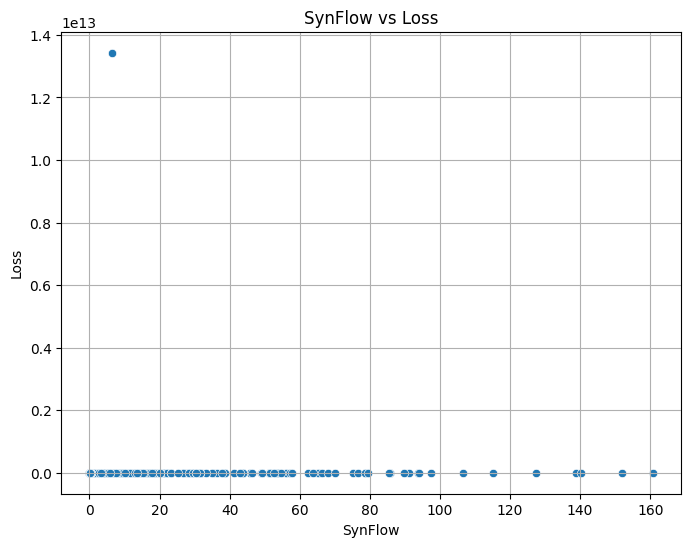

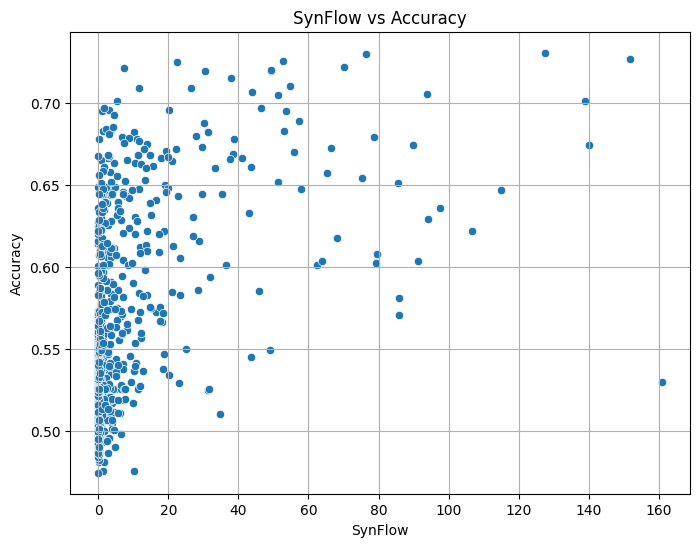

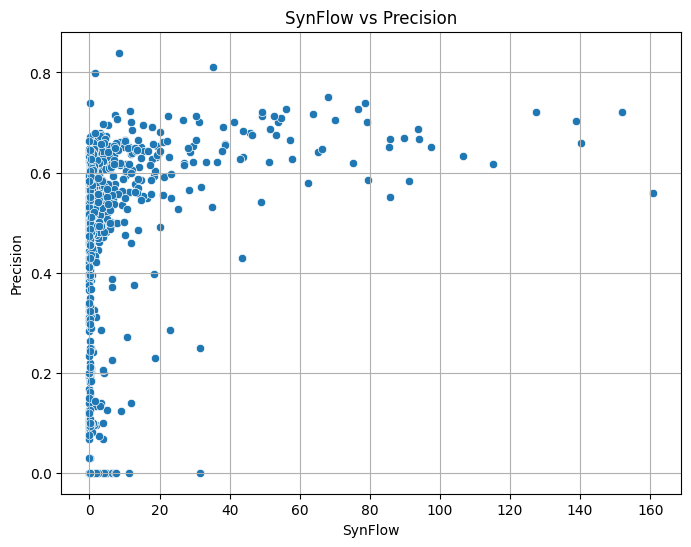

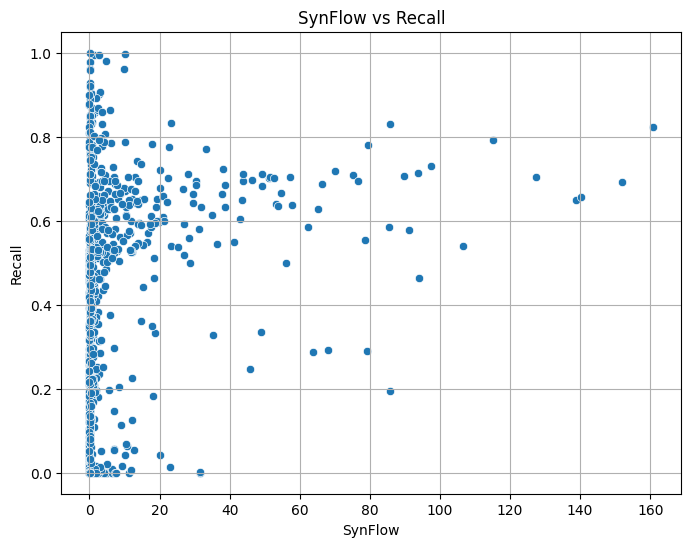

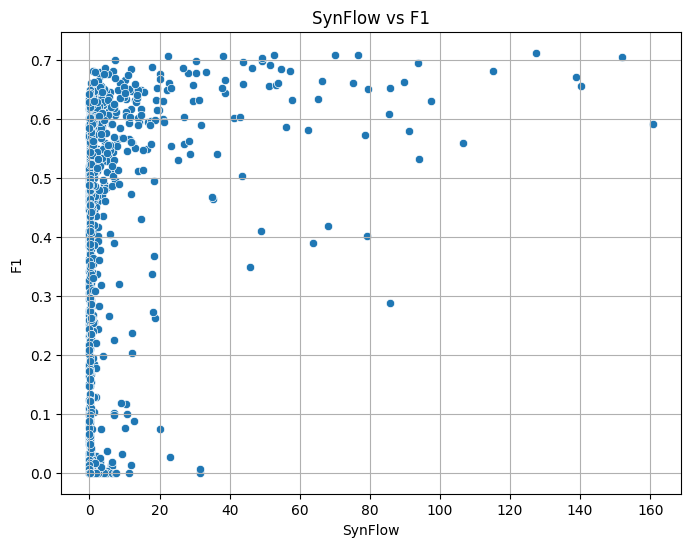

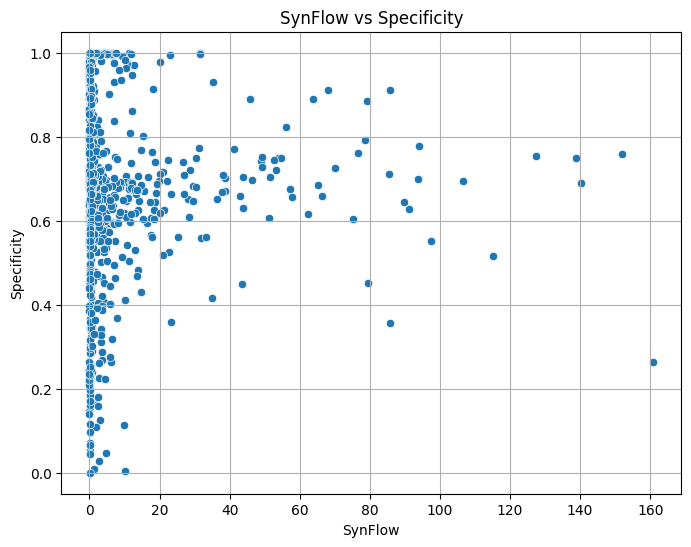

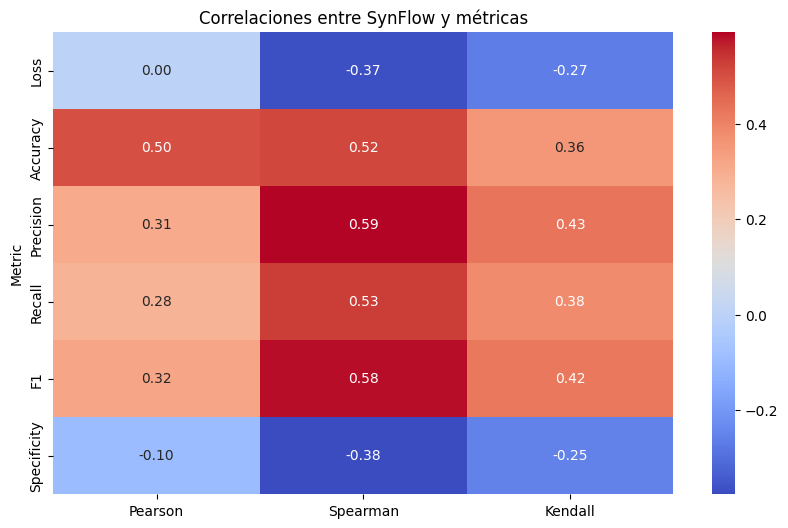

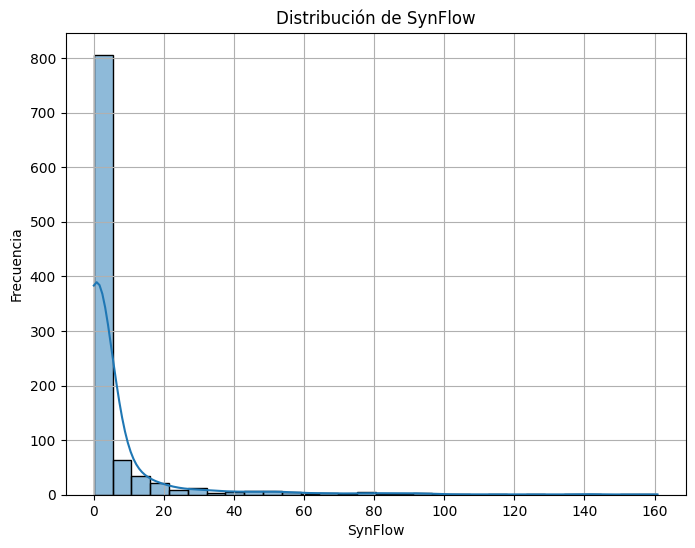

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import r2_score

# Función para calcular todas las métricas de correlación
def compute_correlations(x, y):
    r2 = r2_score(y, x)
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    kendall_corr, _ = kendalltau(x, y)
    return r2, pearson_corr, spearman_corr, kendall_corr

# Leer el dataset con SynFlow ya calculado
dataset_path = "dataset_with_synflow.csv"  # Cambia esto a tu ruta
df = pd.read_csv(dataset_path)

# Calcular correlaciones para cada métrica
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
correlations = []

for metric in metrics:
    r2, pearson, spearman, kendall = compute_correlations(df['SynFlow'], df[metric])
    correlations.append([metric, r2, pearson, spearman, kendall])

# Crear un DataFrame para las correlaciones
correlation_df = pd.DataFrame(correlations, columns=['Metric', 'R2', 'Pearson', 'Spearman', 'Kendall'])

# Mostrar las correlaciones
print("Correlaciones entre SynFlow y métricas:")
print(correlation_df)

# Graficar las relaciones
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='SynFlow', y=metric, data=df)
    plt.title(f"SynFlow vs {metric}")
    plt.xlabel("SynFlow")
    plt.ylabel(metric)
    plt.grid()
    plt.show()

# Graficar un heatmap de las correlaciones
plt.figure(figsize=(10, 6))
heatmap_data = correlation_df.set_index('Metric').drop(columns='R2')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlaciones entre SynFlow y métricas")
plt.show()

# Histogramas de SynFlow
plt.figure(figsize=(8, 6))
sns.histplot(df['SynFlow'], kde=True, bins=30)
plt.title("Distribución de SynFlow")
plt.xlabel("SynFlow")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()


# GA



In [ ]:
def int_to_real_dom(num, domain):
  min_i, max_i = domain
  r = (num - min_i) / (max_i - min_i)
  return r

def real_to_int_dom(num, domain):
  min_i, max_i = domain
  value = min_i + num * (max_i - min_i)
  if isinstance(min_i, int) and isinstance(max_i, int):
      value = int(round(value))
  return value

def convert_individual(ind, to_real=True):
    real_rep = []
    N = max(layer_type_options.keys())
    for i in range(0, len(ind), 4):
        layer_type_idx = ind[i]
        domain_layer_type = [0, N]
        if to_real:
            real_rep.append(int_to_real_dom(layer_type_idx, domain_layer_type))
            layer_type = layer_type_options.get(layer_type_idx, 'DontCare')
        else:
            real_rep.append(real_to_int_dom(layer_type_idx, domain_layer_type))
            layer_type = layer_type_options.get(real_rep[i], 'DontCare')

        # Decode based on layer type
        if layer_type in ['Conv2D', 'DepthwiseConv2D']:
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [4, 32]))
                real_rep.append(int_to_real_dom(ind[i + 2], [0, 1]))
                real_rep.append(int_to_real_dom(ind[i + 3], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [4, 32]))
                real_rep.append(real_to_int_dom(ind[i + 2], [0, 1]))
                real_rep.append(real_to_int_dom(ind[i + 3], [0, 3]))
        elif layer_type == 'BatchNorm':
            real_rep.extend([0, 0, 0])
        elif layer_type == 'MaxPooling':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [0, 1]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [0, 1]))
            real_rep.extend([0, 0])
        elif layer_type == 'Dropout':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [0, 3]))
            real_rep.extend([0, 0])
        elif layer_type == 'Dense':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [1, 512]))
                real_rep.append(int_to_real_dom(ind[i + 2], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [1, 512]))
                real_rep.append(real_to_int_dom(ind[i + 2], [0, 3]))
            real_rep.append(0)
        elif layer_type == 'Flatten':
            real_rep.extend([0, 0, 0])
        elif layer_type == 'Repetition':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [1, 4]))
                real_rep.append(int_to_real_dom(ind[i + 2], [1, 32]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [1, 4]))
                real_rep.append(real_to_int_dom(ind[i + 2], [1, 32]))
            real_rep.append(0)
        elif layer_type == 'DontCare':
            real_rep.extend([0, 0, 0])
    return real_rep

In [ ]:
import numpy as np

def get_succ_m(parents, children):
  # Count if mutation was successful than the average parent fitness
  parent_fitness = [parent['fitness'] for parent in parents]
  avg_fitness = np.mean(parent_fitness)

  succ_m_count = sum(1 for child in children if child['fitness'] < avg_fitness)

  return succ_m_count

In [ ]:
def get_cr_points(rp, n):
  indexes = list(range(n))
  j_star = random.sample(indexes, n // 2)

  for j in range(n):
    if random.random() < rp and j not in j_star:
      j_star.append(j)

  return j_star

In [ ]:
def pop_gen(num_models, max_alleles=48):
    """
    Genera una población inicial utilizando el hipercubo latino y las funciones existentes.

    Args:
        num_models: int - Número de individuos a generar.
        max_alleles: int - Número máximo de alelos en los cromosomas.

    Returns:
        list - Lista de diccionarios con individuos y su fitness inicializado a 0.
    """
    archs = []
    dimensions = 12 * 3  # 12 capas, 3 parámetros por capa

    # Generar muestras del hipercubo latino
    latin_samples = generate_latin_hypercube_samples(num_models, dimensions)

    for sample in latin_samples:
        # Transformar cada muestra en una arquitectura
        model_samples = sample.reshape(12, 3)
        model_dict = {
            "layers": [map_to_architecture_params(layer_sample) for layer_sample in model_samples]
        }

        # Codificar el modelo y repararlo
        encoded_chromosome = encode_model_architecture(model_dict, max_alleles=max_alleles)
        repaired_architecture = fixArch(encoded_chromosome)

        # Añadir a la población
        archs.append({'individual': repaired_architecture, 'fitness': 0})

    return archs


In [ ]:
from tqdm import tqdm

def es(target_func, mu=10, lamb=1, F=2, rp=0.5, gens=100, n=10, auto_adapt=False):
    # Initialize parent population
    pop = pop_gen(mu)
    succ_m_count = 0
    best_fitness_per_gen = []
    Fs = []

    # Barra de progreso para generaciones
    with tqdm(total=gens, desc="Generations", leave=False) as pbar_gens:
        for gen in range(gens):
            children = []

            # Calc fitness and select best element
            pop = [{'individual': parent['individual'], 'fitness': target_func(parent['individual'])} for parent in pop]
            best_parent = max(pop, key=lambda x: x['fitness'])

            for i in range(lamb):
                parent = pop[i]['individual']

                # Map individuals to real values
                parent_unit = convert_individual(parent)
                best_parent_c = convert_individual(best_parent['individual'])

                # Mutation and repair mechanism
                x2, x3 = random.sample(pop, 2)
                x2 = convert_individual(x2['individual'])
                x3 = convert_individual(x3['individual'])
                u = []
                for j in range(len(best_parent_c)):
                    u.append(best_parent_c[j] + F * (x2[j] - x3[j]))
                u = fixArch(convert_individual(u, to_real=False))
                u = convert_individual(u)

                # Recombination
                cr_points = get_cr_points(rp, len(parent))
                child = [u[j] if j in cr_points else parent[j] for j in range(len(u))]
                child = fixArch(convert_individual(child, to_real=False))

                children.append({'individual': child, 'fitness': 0})

                # Calc fitness of children
                children = [{'individual': child['individual'], 'fitness': target_func(child['individual'])} for child in children]

            # Select the best mu elements for next gen
            complete_pop = pop + children

            if(auto_adapt):
                # Count succesful mutations
                succ_m_count += get_succ_m(pop, children)

                # During each time window (n) self-adapt F
                if (gen + 1) % n == 0:
                    Fs.append(F)
                    ps = succ_m_count / (n * lamb)

                    if ps > 1/5:
                        F /= 0.817
                    elif ps < 1/5:
                        F *= 0.817

                    succ_m_count = 0

                pop = sorted(complete_pop, key=lambda x: x['fitness'], reverse=True)[:mu]
                best_fitness_per_gen.append(max(pop, key=lambda x: x['fitness'])['fitness'])

            # Actualizar la barra de progreso de generaciones
            pbar_gens.update(1)

    best_element = max(pop, key=lambda x: x['fitness'])
    Fs.append(F)
    return best_element, best_fitness_per_gen, Fs


In [ ]:
import copy

def eval_arch(ind):
  ind_c = copy.deepcopy(ind)
  reshaped_ind_c = np.array(ind_c).reshape(1, -1)
  acc = model.predict(reshaped_ind_c)
  return acc[0]

In [ ]:
from tqdm import tqdm

best_models = []
all_best_fitness = []
F_arr = []
# Agregar tqdm para mostrar progreso
for i in tqdm(range(30), desc="Running Experiments"):

    best_model, best_fitness_per_gen, Fs = es(
        eval_arch,
        gens=1000,
        F=0.5,
        mu=5000,
        auto_adapt=True
    )
    F_arr.append(Fs)
    best_models.append(best_model)
    all_best_fitness.append(best_fitness_per_gen)


In [ ]:
import matplotlib.pyplot as plt

# Determine the maximum number of generations across all runs
max_generations = max(len(fitness) for fitness in all_best_fitness)
generations = np.arange(1, max_generations + 1)

# Initialize a matrix to hold all fitness values, handling varying lengths
fitness_matrix = np.full((30, max_generations), np.nan)

for i, best_fitness_per_gen in enumerate(all_best_fitness):
    fitness_length = len(best_fitness_per_gen)
    fitness_matrix[i, :fitness_length] = best_fitness_per_gen

# Plot all runs in light gray
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.plot(
        generations,
        fitness_matrix[i],
        linestyle='-',
        color='red',
        alpha=0.5
    )

# Compute the mean and standard deviation across runs at each generation
mean_fitness = np.nanmean(fitness_matrix, axis=0)
std_fitness = np.nanstd(fitness_matrix, axis=0)

# Plot the mean best fitness
plt.plot(
    generations,
    mean_fitness,
    linestyle='-',
    color='blue',
    label='Mean Accuracy'
)

# Fill the area between (mean - std) and (mean + std)
plt.fill_between(
    generations,
    mean_fitness - std_fitness,
    mean_fitness + std_fitness,
    color='blue',
    alpha=0.2,
    label='Standard Deviation'
)

plt.title('Convergence Plot of Accuracy per Generation over 30 Runs')
plt.xlabel('Generations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()